## Mike's Lifting Program Calculator

This notebook generates a program based on one variant of the Heavy-Light-Medium (itself a variant of the Heavy-Medium-Light) scheme.

How it works: you pick three lifts; I picked deadlift, squat, and press. Each week you'll do one of them heavy on Monday, one of them light on Wednesday, and one of them medium on Friday. It uses a simple linear progression, running in seven-week cycles of two three-week subcycles plus a rest week.

It isn't smart enough as written to handle anything more complicated than that. If you have an injury or a vacation or something, just re-test and reset your goals.

In practice I superset (meaning, alternate) the lift with an accessory lift. I've been pairing the deadlift with a strict pullup, like chins or weighted pullups or chest-to-bar pullups; the squat with a strict press, like weighted dips or handstand pushups; the barbell press with a row, like pendlay row or single-arm kettlebell row.

This is written in the python programming language. If you don't know python, that's fine: you can still change the loads and dates in the "Goals" section, and re-run the notebook using "Cell > Run All" above to build a program for yourself.

If you do know python, knock yourself out.

### Goals

In this cell we set the start and end goals for the program. In my case, I'm looking to get back to a certain standard of strength after some injuries (and hold it there afterward, for which, different program). I set the standard relative to my bodyweight, and am targeting Jan 1 2018.

If your goals are different, like you're shooting for a 500 pound deadlift, easy enough to change.
I do assume deadlift, squat, and press. If you want to change lifts, that should be easy enough.

In [1]:
BODYWEIGHT = 185

DEADLIFT_MAX_BEGIN = 365
DEADLIFT_MAX_END = 400 # :) 2.0 * BODYWEIGHT

SQUAT_MAX_BEGIN = 310
SQUAT_MAX_END = 1.75 * BODYWEIGHT

PRESS_MAX_BEGIN = 180
PRESS_MAX_END = 1.0 * BODYWEIGHT

DATE_BEGIN = '2017-09-25' # -- expects YYYY-MM-DD format
DATE_END = '2018-01-01'

### Setup/Code

This next part spells out the python code needed to construct the lifting program. If you just want to see your program, make sure you've done a "Cell > Run All" and scroll to the bottom of the page.

In [2]:
import datetime
import itertools
import math
import pandas as pd
import seaborn as sns
from IPython.display import HTML

sns.set_style('darkgrid')
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# -- A few of the standard 1RM formulas:
#    https://en.wikipedia.org/wiki/One-repetition_maximum
#    http://rodrigoborges.hospedagemdesites.ws/principal/pdf/avaliacao_02.pdf
# -- type-hints are gratuitous; just curious
def epley(w: float, r: int) -> float:
    return w * (1 + r / 30)

def inv_epley(y:float, r:int) -> float:
    return y / (1 + r / 30)

def brzycki(w: float, r: int) -> float:
    return w * 36 / (37 - r)

def inv_brzycki(y:float, r:int) -> float:
    return y * (37 - r) / 36

_mh = lambda r: (52.2 + 41.9 * math.exp(-0.055 * r))
def mayhew(w, r):
    return 100 * w / _mh(r)

def inv_mayhew(y, r):
    return y * _mh(r) / 100

_w = lambda r: (48.8 + 53.8 * math.exp(-0.075 * r))
def wathan(w, r):
    return 100 * w / _w(r)

def inv_wathan(y, r):
    return y * _w(r) / 100

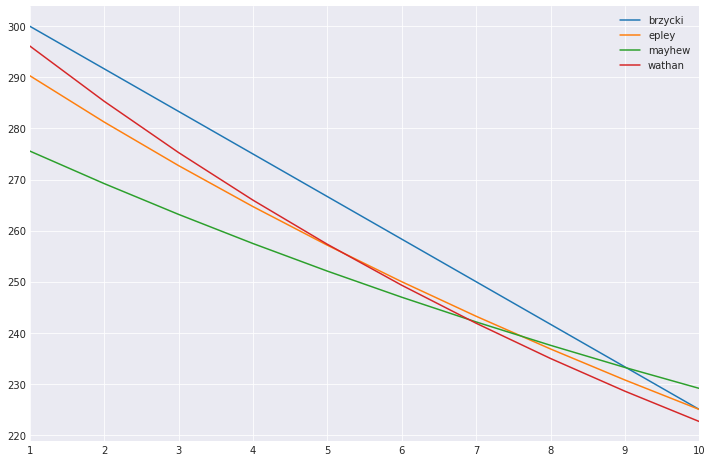

In [5]:
# -- shows how the 1RM formulas trail off given a 1RM.
# -- Mayhew seems really different/wrong, but it matches what's in the JSCR reference

ref = 300
trace = lambda f: [f(ref, r + 1) for r in range(10)]
traces = \
dict(epley=trace(inv_epley),
     brzycki=trace(inv_brzycki),
     mayhew=trace(inv_mayhew),
     wathan=trace(inv_wathan)
    )
df = pd.DataFrame(traces, index=trace(lambda x, y: y))
df.plot(figsize=(12, 8));

# -- for what follows, use Wathan formula
rep_fn = wathan
inv_rep_fn = inv_wathan

In [6]:
def parse_ymd_date(date_str):
    "Input eg 2017-06-19 => June 19th, 2017."
    try:
        return datetime.datetime.strptime(date_str, '%Y-%m-%d').date()
    except ValueError:
        print('Expected a date like "YYYY-MM-DD", you supplied "{}".'.format(date_str))
#parse_ymd_date(DATE_BEGIN)

In [7]:
MON, TUE, WED, THU, FRI, SAT, SUN = range(7) # -- python's convention

def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead < 0: # Target day already happened this week
        days_ahead += 7
    return d + datetime.timedelta(days_ahead)
next_monday = lambda d: next_weekday(d, MON)

def daterange(start_date, end_date, step=1):
    cur = start_date
    while cur <= end_date:
        yield cur
        cur += datetime.timedelta(days=step)

def rotations(seq):
    return (seq[i:] + seq[:i] for i in range(len(seq)))

def interpolate_1rm(at_date, start_date, end_date, start_1rm, end_1rm):
    "y – y1 = m(x – x1) => y = m(x - x1) + y1"
    m = (end_1rm - start_1rm) / (end_date - start_date).total_seconds()
    return m * (at_date - start_date).total_seconds() + start_1rm

def snap_to(x, r=1):
    'Round to nearest integer `r`.'
    return r * round(x / r)

In [8]:
MESOCYCLE_LENGTH = 7 # weeks, this program is two three-week cycles and one rest/deload week

REP_BASE = 4 # -- this can be changed; how many reps you do per set
SET_BASE = 5 # -- this cannot be changed (as written); how many sets on a "Heavy" day

NUM_SETS_MAP = dict(heavy=5, medium=4, light=3)
SNAP_MAP = dict(Deadlift=5, Squat=5, Press=1)

date_begin = next_monday(parse_ymd_date(DATE_BEGIN))
date_end = next_monday(parse_ymd_date(DATE_END))

lift_default_order = ('Deadlift', 'Squat', 'Press')
mesocycle = list(rotations(lift_default_order)) + list(rotations(lift_default_order)) + ['rest']

deadlift_1rm = lambda d: interpolate_1rm(d, date_begin, date_end, DEADLIFT_MAX_BEGIN, DEADLIFT_MAX_END)
squat_1rm = lambda d: interpolate_1rm(d, date_begin, date_end, SQUAT_MAX_BEGIN, SQUAT_MAX_END)
press_1rm = lambda d: interpolate_1rm(d, date_begin, date_end, PRESS_MAX_BEGIN, PRESS_MAX_END)

def lifts_asof(d):
    return dict(Deadlift=deadlift_1rm(d),
                Squat=squat_1rm(d),
                Press=press_1rm(d))

def make_set(max_, num_sets, rep_base=REP_BASE, set_base=SET_BASE, res=1):
    initial_repmax = (rep_base + set_base - 1)
    repmaxes_by_set = [initial_repmax - i for i in range(num_sets)]
    return [snap_to(inv_rep_fn(max_, rm), res) for rm in repmaxes_by_set]

In [9]:
# -- build program
mesocycle_start_dates = list(daterange(date_begin, date_end, step=7 * MESOCYCLE_LENGTH))

html = []

for msi, ms in enumerate(mesocycle_start_dates):
    # -- determine 1RMs for the mesocycle
    # -- without great justification, or great worry, I define as the working 1RM
    #    the Monday of the second week of each three-week cycle
    ref_1rm_1 = ms + datetime.timedelta(2 * 7)
    ref_1rm_2 = ms + datetime.timedelta(5 * 7)
    
    lifts_1rm_1 = lifts_asof(ref_1rm_1)
    lifts_1rm_2 = lifts_asof(ref_1rm_2)
    
    maxes_by_week = [lifts_1rm_1] * 3 + [lifts_1rm_2] * 3 + [None]
    
    week_starts = daterange(ms, ms + datetime.timedelta(7 * MESOCYCLE_LENGTH - 1), step=7)
    
    html.append("<h3>Mesocycle {} of {}</h3><hr/>".format(msi + 1, len(mesocycle_start_dates)))
    for week, lifts, maxes in zip(week_starts, mesocycle, maxes_by_week):
        html.append('<h4>Week of {}</h4>'.format(datetime.datetime.strftime(week, '%B %e, %Y')))
        if lifts == 'rest':
            html.append('Rest Week!')
        else:
            # -- this is one week
            html.append('<p><i>Working Maxes: {}</i></p><br/>'.format('&nbsp;&nbsp;'.join('{} {:.0f}'.format(*e) for e in sorted(maxes.items(), key=lambda k: k[1]))))
            dates = daterange(week, week + datetime.timedelta(5), step=2)
            scheme = ('heavy', 'light', 'medium')
            for day, lift, lift_type in zip(dates, lifts, scheme):
                this_set = make_set(maxes[lift], NUM_SETS_MAP[lift_type], res=SNAP_MAP[lift])
                html.append('&nbsp;<strong>{}</strong><br/>'.format(datetime.datetime.strftime(day, '%A, %b %e')))
                html.append('&nbsp;{} {}X {}<br/><br/>'.format(lift, REP_BASE, ' '.join(str(e) for e in this_set)))
    html.append('<hr/>')

### Your Program!

In [10]:
HTML(''.join(html))